In [96]:
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timezone
from scipy.optimize import minimize

In [97]:
# Headers for API
headers = {
    "User-Agent": "My Python Application. Contact me at mattdh12@gmail.com"
}

In [98]:
# Fetch PGNs
def fetch_latest_pgns(username, max_games=5):
    archive_url = f"https://api.chess.com/pub/player/{username}/games/archives"
    archive_data = requests.get(archive_url, headers=headers).json()
    latest_url = archive_data["archives"][-1]
    games = requests.get(latest_url, headers=headers).json()["games"]
    return [game["pgn"] for game in sorted(games, key=lambda g: g["end_time"], reverse=True) if game["time_control"] == "600"][:max_games]

# Extract times
def detect_color(pgn, username):
    white = re.search(r'\[White "(.*?)"\]', pgn).group(1).lower()
    return username.lower() == white

def extract_player_times_fixed(pgn, is_white=True):
    matches = re.findall(r'\[%clk (\d+):(\d+):(\d+)(?:\.(\d+))?\]', pgn)
    times = [int(h) * 3600 + int(m) * 60 + int(s) for h, m, s, _ in matches]
    return times[::2] if is_white else times[1::2]

In [99]:
# Get and process games
username = "mattdh12"
recent_games = fetch_latest_pgns(username, max_games=5)
colors = [detect_color(pgn, username) for pgn in recent_games]
move_time_series = [extract_player_times_fixed(pgn, is_white) for pgn, is_white in zip(recent_games, colors)]

# Pad and convert to minutes
max_moves = max(len(times) for times in move_time_series)
move_time_series_minutes = [
    [t / 60 for t in times] + [None] * (max_moves - len(times)) for times in move_time_series
]
average_curve = np.nanmean(
    np.array([[t if t is not None else np.nan for t in game] for game in move_time_series_minutes]),
    axis=0
)

In [100]:
def smooth_phase_s_curve(midpoint, steepness, total_moves=60, total_minutes=10):
    x = np.arange(0, total_moves + 1)
    sigmoid = 1 / (1 + np.exp(steepness * (x - midpoint)))
    sigmoid -= sigmoid[-1]
    sigmoid *= total_minutes / sigmoid[0]
    return x, sigmoid

def compute_phase_totals(y, phases):
    return [np.sum(-np.diff(y[start:end+1])) for start, end in phases]

def phase_loss(params, targets, total_moves=60):
    midpoint, steepness = params
    _, y = smooth_phase_s_curve(midpoint, steepness, total_moves)
    actuals = compute_phase_totals(y, [(0,10), (10,30), (30,60)])
    return np.sum(np.abs(np.array(actuals) - np.array(targets)))  # use absolute error

# Target phase times in minutes
targets = [1.5, 4.5, 4.0]

# Start from your best manual guess
initial_guess = [23.5, 0.07375]
bounds = [(20, 30), (0.05, 0.15)]

result = minimize(phase_loss, initial_guess, args=(targets,), bounds=bounds)
mid_opt, steep_opt = result.x

print(f"Optimized midpoint: {mid_opt:.4f}, steepness: {steep_opt:.5f}")
_, y_opt = smooth_phase_s_curve(mid_opt, steep_opt)

actuals = compute_phase_totals(y_opt, [(0,10), (10,30), (30,60)])
print(f"Opening (1–10): {actuals[0]:.2f} min (Target: 1.5)")
print(f"Middlegame (11–30): {actuals[1]:.2f} min (Target: 4.5)")
print(f"Endgame (31–60): {actuals[2]:.2f} min (Target: 4.0)")

Optimized midpoint: 23.4946, steepness: 0.07689
Opening (1–10): 1.50 min (Target: 1.5)
Middlegame (11–30): 4.50 min (Target: 4.5)
Endgame (31–60): 4.00 min (Target: 4.0)


In [ ]:
def smooth_phase_s_curve(total_moves=60, total_minutes=10):
    x = np.arange(0, total_moves + 1)
    
    midpoint = mid_opt        # Phase transition tuning
    steepness = steep_opt    # Very slight tweak to get exact match
    
    sigmoid = 1 / (1 + np.exp(steepness * (x - midpoint)))
    
    sigmoid -= sigmoid[-1]
    sigmoid *= total_minutes / sigmoid[0]
    
    return x, sigmoid

# Usage:
target_x, s_curve_minutes = smooth_phase_s_curve(total_moves=60)

In [102]:
opening_used = s_curve_minutes[0] - s_curve_minutes[10]
middlegame_used = s_curve_minutes[10] - s_curve_minutes[30]
endgame_used = s_curve_minutes[30] - s_curve_minutes[60]

print(f"Opening (1–10): {opening_used:.2f} min (Target: 1.5)")
print(f"Middlegame (11–30): {middlegame_used:.2f} min (Target: 4.5)")
print(f"Endgame (31–60): {endgame_used:.2f} min (Target: 4.0)")

Opening (1–10): 1.50 min (Target: 1.5)
Middlegame (11–30): 4.50 min (Target: 4.5)
Endgame (31–60): 4.00 min (Target: 4.0)


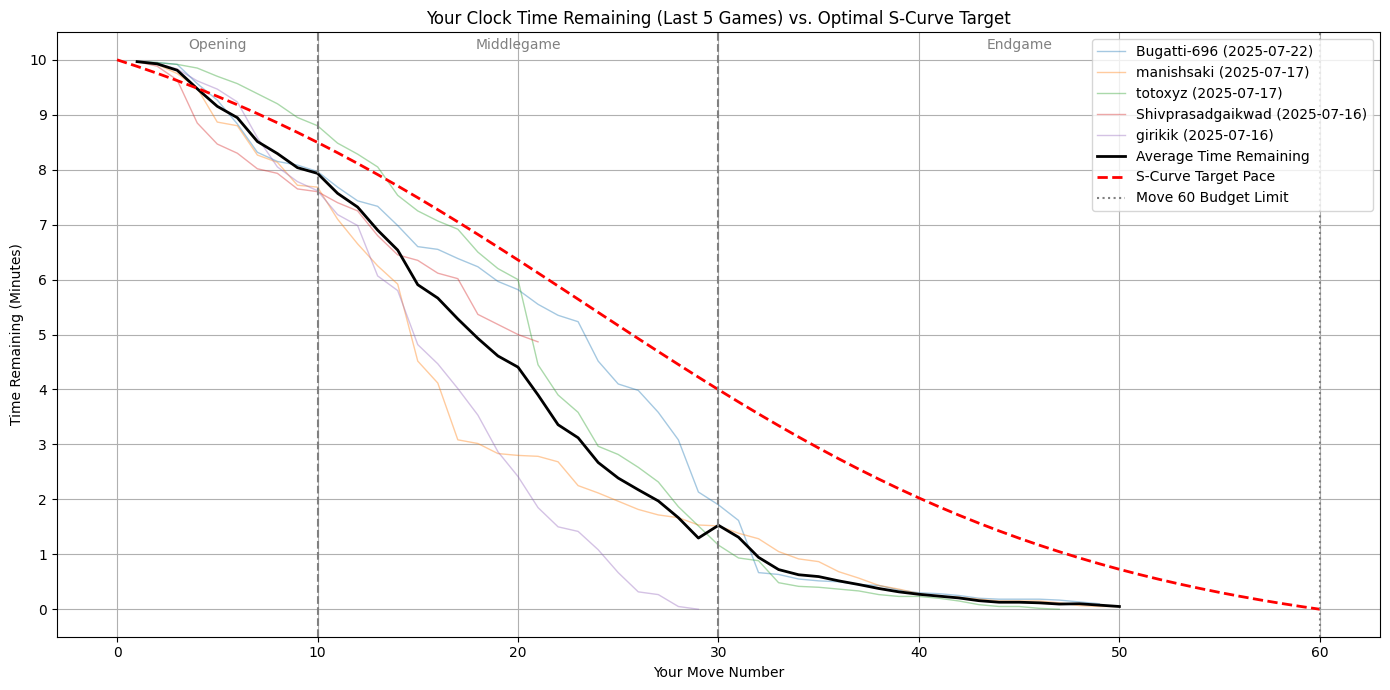

In [113]:
# Generate distinct colors
cmap = plt.colormaps.get_cmap('tab10')
num_games = len(recent_games)
colors_list = [cmap(i % 10) for i in range(num_games)]

# Plot
plt.figure(figsize=(14, 7))
for idx, (pgn, times) in enumerate(zip(recent_games, move_time_series_minutes)):
    # Extract opponent and date
    white = re.search(r'\[White "(.*?)"\]', pgn).group(1)
    black = re.search(r'\[Black "(.*?)"\]', pgn).group(1)
    opponent = black if username.lower() == white.lower() else white
    end_time_match = re.search(r'\[EndTime "(.*?)"\]', pgn)
    timestamp = re.search(r'\[UTCDate "(.*?)"\]', pgn)
    if timestamp:
        date_str = timestamp.group(1).replace('.', '-')
    else:
        date_str = f"Game {idx+1}"
    
    label = f"{opponent} ({date_str})"
    plt.plot(range(1, len(times) + 1), times, alpha=0.4, linewidth=1, label=label, color=colors_list[idx])

# Plot average line and target
plt.plot(range(1, len(average_curve) + 1), average_curve, color='black', linewidth=2, label='Average Time Remaining')
plt.plot(target_x, s_curve_minutes, linestyle='--', color='red', linewidth=2, label='S-Curve Target Pace')
plt.axvline(x=60, color='gray', linestyle=':', label='Move 60 Budget Limit')

# Phase indicators
plt.axvline(x=10, color='gray', linestyle='--', linewidth=1.5)
plt.axvline(x=30, color='gray', linestyle='--', linewidth=1.5)

# Phase labels
plt.text(5, 10.2, 'Opening', ha='center', fontsize=10, color='gray')
plt.text(20, 10.2, 'Middlegame', ha='center', fontsize=10, color='gray')
plt.text(45, 10.2, 'Endgame', ha='center', fontsize=10, color='gray')

plt.xlabel('Your Move Number')
plt.ylabel('Time Remaining (Minutes)')
plt.title('Your Clock Time Remaining (Last 5 Games) vs. Optimal S-Curve Target')
plt.yticks(range(0, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

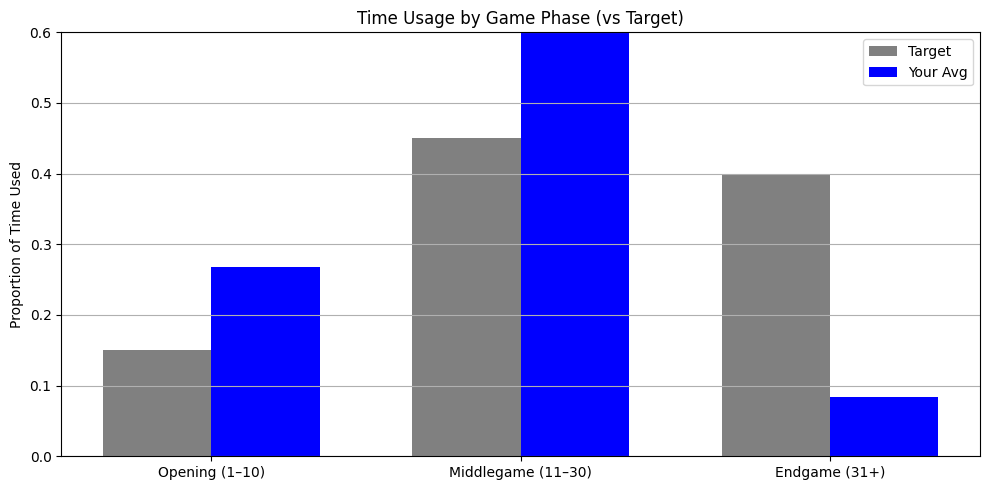

In [104]:
# Time Phase Goals Plot

phase_labels = ['Opening (1–10)', 'Middlegame (11–30)', 'Endgame (31+)']
phase_targets = [0.15, 0.45, 0.40]  # Target percentages

phase_actuals = np.zeros(3)

for times in move_time_series:
    if not times:
        continue
    diffs = np.diff(times)
    phase_actuals[0] += sum(diffs[:10])
    phase_actuals[1] += sum(diffs[10:30])
    phase_actuals[2] += sum(diffs[30:])

total_time = sum(phase_actuals)
phase_actuals_percent = phase_actuals / total_time

x = np.arange(3)
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, phase_targets, width, label='Target', color='gray')
plt.bar(x + width/2, phase_actuals_percent, width, label='Your Avg', color='blue')

plt.ylabel('Proportion of Time Used')
plt.title('Time Usage by Game Phase (vs Target)')
plt.xticks(x, phase_labels)
plt.ylim(0, 0.6)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

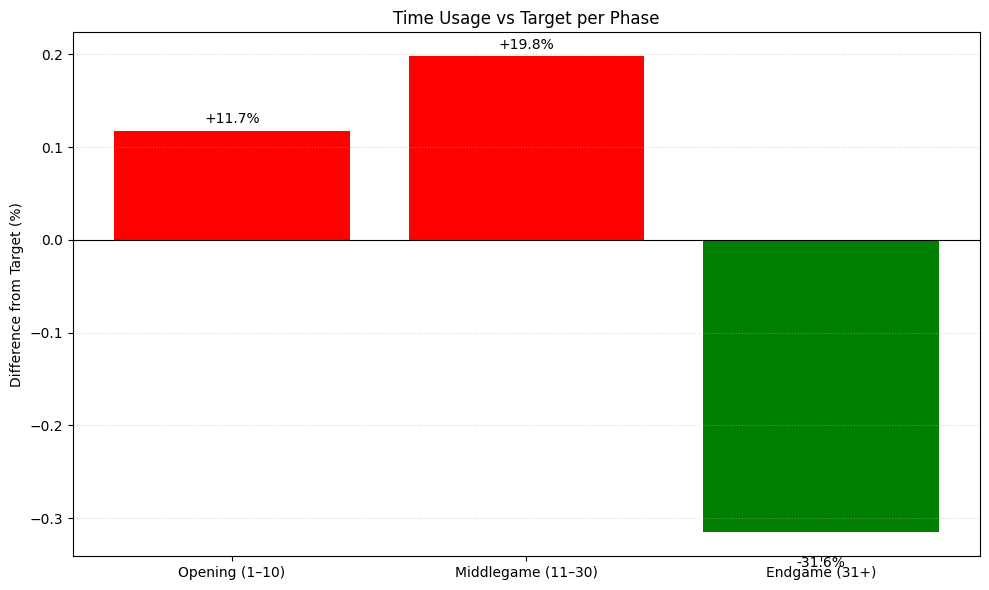

In [105]:
# Time Phase Goals Plot with Difference Annotations

phase_labels = ['Opening (1–10)', 'Middlegame (11–30)', 'Endgame (31+)']
phase_targets = [0.15, 0.45, 0.40]  # Target percentages

phase_actuals = np.zeros(3)

for times in move_time_series:
    if not times:
        continue
    diffs = np.diff(times)
    phase_actuals[0] += sum(diffs[:10])
    phase_actuals[1] += sum(diffs[10:30])
    phase_actuals[2] += sum(diffs[30:])

total_time = sum(phase_actuals)
phase_actuals_percent = phase_actuals / total_time
phase_diffs = phase_actuals_percent - phase_targets

x = np.arange(3)
width = 0.35

# Time Phase Target Difference Only
plt.figure(figsize=(10, 6))
bar_colors = ['green' if diff < 0 else 'red' for diff in phase_diffs]
plt.bar(phase_labels, phase_diffs, color=bar_colors)

for i, diff in enumerate(phase_diffs):
    sign = '+' if diff > 0 else ''
    plt.text(i, diff + 0.005 if diff > 0 else diff - 0.025, f'{sign}{diff:.1%}',
             ha='center', va='bottom' if diff > 0 else 'top', fontsize=10)

plt.axhline(0, color='black', linewidth=0.8)
plt.title('Time Usage vs Target per Phase')
plt.ylabel('Difference from Target (%)')
plt.tight_layout()
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()